In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Reshape
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Reshape, LSTM, Dense, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Reshape, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Layer

In [ ]:
def load_images(folder_path, image_size=(128,128)):
    data = []
    labels = []

    label = os.path.basename(folder_path)  # Extract the label from the folder name

    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):  # Check if it is a file
            img = cv2.imread(img_path)
            if img is not None:  # Check if the image was read correctly
                img = cv2.resize(img, image_size)  # Resize images to a common size
                data.append(img)
                labels.append(label)

    return np.array(data), np.array(labels)

dataset_path = r"E:\Dataset\Bone Fracture Multi-Region X-ray Data"

# Load images for each type of chest X-ray
data_fractured, labels_fractured = load_images(os.path.join(dataset_path, 'fractured'))
data_not_fractured, labels_not_fractured = load_images(os.path.join(dataset_path, 'not_fractured'))

In [ ]:
data_fractured.shape

In [ ]:
data_not_fractured.shape

In [ ]:
# Combine data and labels for all tumor types
All_data = np.concatenate([data_fractured, data_not_fractured])
All_labels = np.concatenate([labels_fractured, labels_not_fractured])

In [ ]:
import random
def show_images(images, labels, num_images=10):
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        index = random.randint(0, len(images) - 1)  # Randomly select an image
        plt.subplot(2, 5, i + 1)
        plt.imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
        plt.title(labels[index])
        plt.axis('off')
    plt.show()

# Display 10 random images from the dataset
show_images(All_data, All_labels)

In [ ]:
unique_labels, label_counts = np.unique(All_labels, return_counts=True)
plt.figure(figsize=(8, 6))
plt.bar(unique_labels, label_counts, color=['red', 'green'])
plt.xlabel('Diseases Types')
plt.ylabel('Number of Samples')
plt.title('Distribution of Diseases Types in the Dataset')
for i, count in enumerate(label_counts):
    plt.text(i, count + 20, str(count), ha='center', va='bottom')

plt.xticks(unique_labels, ['fractured', 'not_fractured'])
plt.show()

In [ ]:
# Normalize Pixel Values
All_data_normalized = All_data / 255.0

In [ ]:
# Encode Labels
label_encoder = LabelEncoder()
all_labels_encoded = label_encoder.fit_transform(All_labels)
all_labels_categorical = to_categorical(all_labels_encoded)
train_data, test_data, train_labels, test_labels = train_test_split(
    All_data_normalized, all_labels_categorical, test_size=0.15, random_state=42)

In [ ]:
train_data.shape

In [ ]:
test_data.shape

In [ ]:
all_labels_categorical.shape

In [10]:
image_size = (64, 64)

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[-1],), initializer="zeros", trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        et = tf.nn.tanh(tf.tensordot(x, self.W, axes=(2, 0)) + self.b)
        at = tf.nn.softmax(et, axis=1)
        ot = x * at
        return tf.reduce_sum(ot, axis=1)

In [12]:
from tensorflow.keras.models import Model
inputs = Input(shape=(image_size + (3,)))

# CNN layers with Dropout
x = Conv2D(16, kernel_size=(3, 3), activation="relu")(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)  # Adding Dropout after the first max pooling layer
x = Conv2D(32, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)  # Adding Dropout after the second max pooling layer
x = Flatten()(x)

# Reshape the output to fit the LSTM input
x = Reshape((1, -1))(x)

# Single LSTM layer with Dropout
lstm_out = LSTM(50, return_sequences=True)(x)
lstm_out = Dropout(0.3)(lstm_out)  # Adding Dropout after LSTM layer

# Attention mechanism
attention_output = Attention()(lstm_out)

# Skip connection to final dense layer
combined_output = Add()([attention_output, tf.reduce_sum(lstm_out, axis=1)])

# Final dense layer
outputs = Dense(2, activation="softmax")(combined_output)

# Define the combined model
combined_model = Model(inputs=inputs, outputs=outputs)

# Compile the model
combined_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Callbacks
checkpoint_callback = ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss", mode="min")
early_stopping_callback = EarlyStopping(patience=2, monitor="val_loss", mode="min", restore_best_weights=True)

# Model summary
combined_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 62, 62, 16)           448       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 31, 31, 16)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 dropout (Dropout)           (None, 31, 31, 16)           0         ['max_pooling2d[0][0]']   

In [13]:
history = combined_model.fit(
    train_data,
    train_labels,
    epochs=40,
    batch_size=16,
    validation_split=0.15,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/40
418/418 [==============================] - 24s 51ms/step - loss: 0.4458 - accuracy: 0.7791 - val_loss: 0.2153 - val_accuracy: 0.9389
Epoch 2/40
  1/418 [..............................] - ETA: 21s - loss: 0.2656 - accuracy: 0.8125

C:\Users\ASUS\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


418/418 [==============================] - 20s 47ms/step - loss: 0.1763 - accuracy: 0.9329 - val_loss: 0.1134 - val_accuracy: 0.9576
Epoch 3/40
418/418 [==============================] - 20s 47ms/step - loss: 0.0881 - accuracy: 0.9688 - val_loss: 0.0525 - val_accuracy: 0.9830
Epoch 4/40
418/418 [==============================] - 19s 46ms/step - loss: 0.0492 - accuracy: 0.9817 - val_loss: 0.0554 - val_accuracy: 0.9830
Epoch 5/40
418/418 [==============================] - 18s 44ms/step - loss: 0.0332 - accuracy: 0.9880 - val_loss: 0.0304 - val_accuracy: 0.9932
Epoch 6/40
418/418 [==============================] - 18s 44ms/step - loss: 0.0274 - accuracy: 0.9912 - val_loss: 0.0318 - val_accuracy: 0.9898
Epoch 7/40
418/418 [==============================] - 18s 44ms/step - loss: 0.0201 - accuracy: 0.9930 - val_loss: 0.0331 - val_accuracy: 0.9898


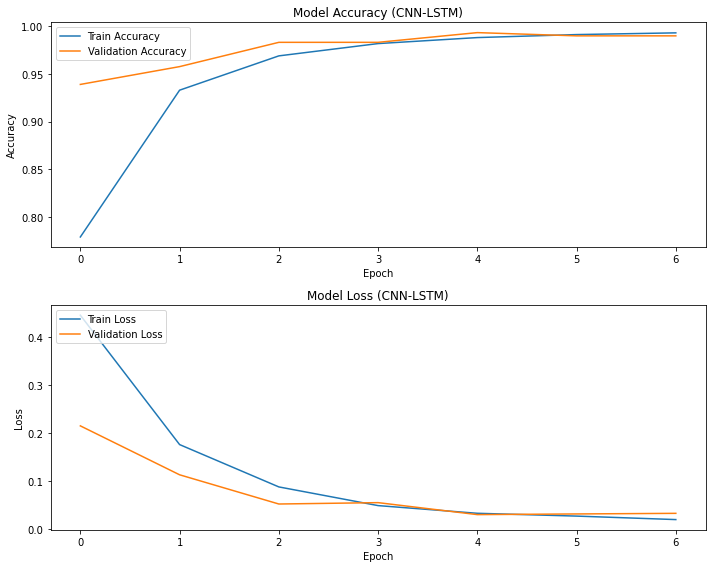

In [14]:
# Create a figure with subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot Accuracy
axs[0].plot(history.history['accuracy'], label='Train Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Model Accuracy (CNN-LSTM)')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='upper left')

# Plot Loss
axs[1].plot(history.history['loss'], label='Train Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Model Loss (CNN-LSTM)')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

In [15]:
loss, accuracy = combined_model.evaluate(test_data, test_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

44/44 [==============================] - 1s 13ms/step - loss: 0.0722 - accuracy: 0.9856
Test Accuracy: 98.56%


In [16]:
# Predictions and classification report
y_pred = combined_model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

44/44 [==============================] - 1s 14ms/step
               precision    recall  f1-score   support

    fractured       0.98      0.99      0.99       695
not_fractured       0.99      0.98      0.99       692

     accuracy                           0.99      1387
    macro avg       0.99      0.99      0.99      1387
 weighted avg       0.99      0.99      0.99      1387



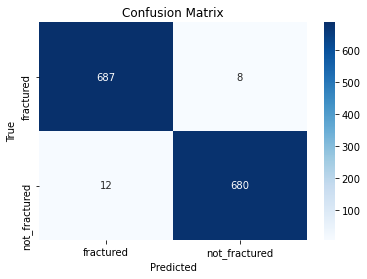

In [17]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [19]:
#combined_model.save("trained_combined_model_Attention.h5")

C:\Users\ASUS\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


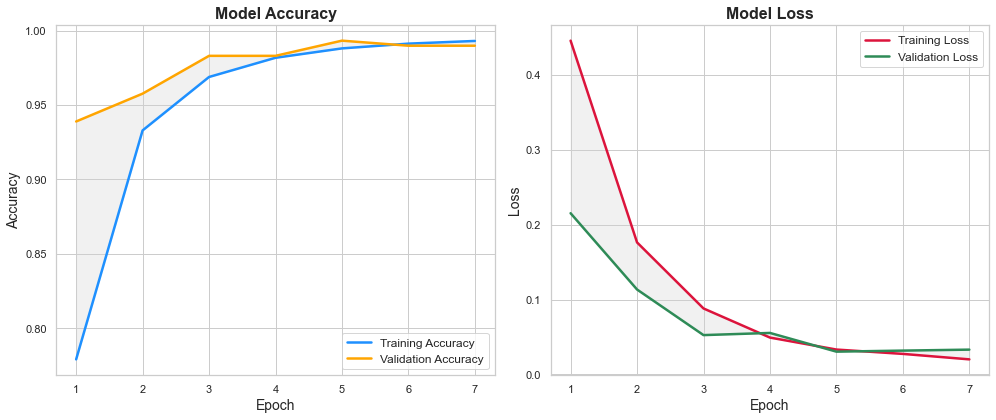

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a beautiful style for the plots
sns.set(style="whitegrid")

# Manually inputting the values based on the provided history
epochs = list(range(1, 8))
train_loss = [0.4458, 0.1763, 0.0881, 0.0492, 0.0332, 0.0274, 0.0201]
train_accuracy = [0.7791, 0.9329, 0.9688, 0.9817, 0.9880, 0.9912, 0.9930]
val_loss = [0.2153, 0.1134, 0.0525, 0.0554, 0.0304, 0.0318, 0.0331]
val_accuracy = [0.9389, 0.9576, 0.9830, 0.9830, 0.9932, 0.9898, 0.9898]

# Plotting training & validation accuracy values
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy', color='dodgerblue', linewidth=2.5)
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='orange', linewidth=2.5)
plt.fill_between(epochs, train_accuracy, val_accuracy, color='lightgray', alpha=0.3)
plt.title('Model Accuracy', fontsize=16, weight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss', color='crimson', linewidth=2.5)
plt.plot(epochs, val_loss, label='Validation Loss', color='seagreen', linewidth=2.5)
plt.fill_between(epochs, train_loss, val_loss, color='lightgray', alpha=0.3)
plt.title('Model Loss', fontsize=16, weight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()